# Import Libraries

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras import layers
from keras.models import Model
from keras.utils import plot_model
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder
from keras.models import load_model
from keras.callbacks import LearningRateScheduler
import seaborn as sns


## Load Data, Preprocessing and Data Augmentation

In [2]:
batch_size = 400

In [3]:
data_path = 'D:/University/Deep_Learning/HWs/HW02_/NN_HW2_Face_Emotion/'

In [4]:
def load_data(data_dir, labels):
    images = []
    target_labels = []

    for label in labels:
        label_dir = os.path.join(data_dir, label)
        image_files = os.listdir(label_dir)
        
        for image_file in image_files:
            image_path = os.path.join(label_dir, image_file)

            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            images.append(image)
            target_labels.append(label)

    images = np.array(images)
    target_labels = np.array(target_labels)

    return images, target_labels

In [5]:
labels = os.listdir(data_path + 'TRAIN')

In [6]:
labels

['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [7]:
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [8]:
train_generator = data_gen.flow_from_directory(
    data_path + 'TRAIN',
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 8000 images belonging to 8 classes.


In [9]:
X_train, y_train = load_data(data_path + 'TRAIN', labels)
X_tune, y_tune = load_data(data_path + 'TUNE', labels)

In [10]:
X_train_normalized = X_train / 255.0

In [11]:
X_tune_normalized = X_tune / 255.0

In [12]:
classes = np.array(labels)
classes = classes.reshape(-1, 1)

enc = OneHotEncoder(sparse_output=False)
enc.fit(classes)

y_train_encoded = y_train.reshape(-1, 1)
y_train_encoded = enc.transform(y_train_encoded)
y_tune_encoded = y_tune.reshape(-1, 1)
y_tune_encoded = enc.transform(y_tune_encoded)

In [13]:
for i in range(train_generator.n // (batch_size * 2)):
    batch_images, batch_labels = next(train_generator)
    X_train_normalized = np.concatenate((X_train_normalized, batch_images))
    y_train_encoded = np.concatenate((y_train_encoded, batch_labels))

In [14]:
X_train_normalized.shape

(12000, 128, 128, 3)

In [15]:
def plot_samples(labels, X, y):
    cnt = 1

    for label in labels:
        ind = np.where(y == label)[0][0]
        sample = X[ind]
        plt.subplot(2, 4, cnt)
        plt.imshow(sample)
        plt.xticks([])
        plt.yticks([])
        plt.title(label)
        cnt += 1

    plt.show()

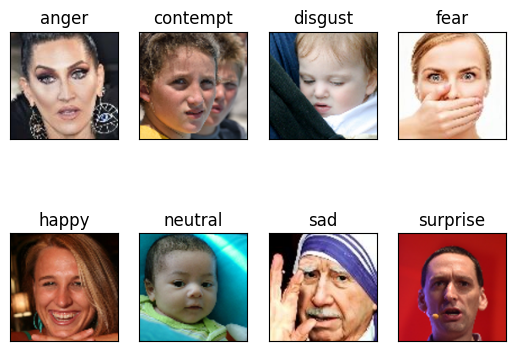

In [16]:
plot_samples(labels, X_train, y_train)

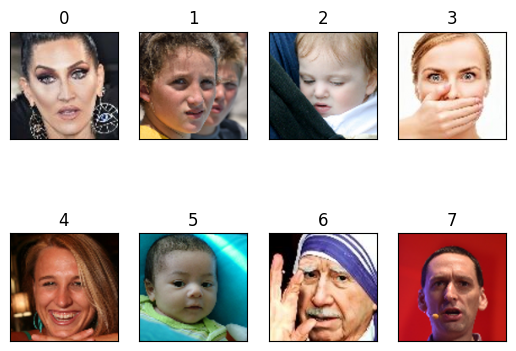

In [17]:
plot_samples(np.unique(np.argmax(y_train_encoded, axis=1)), X_train_normalized,
             np.argmax(y_train_encoded, axis=1))

In [16]:
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_normalized, y_train_encoded,
                                                                      test_size=0.2,
                                                                      random_state=42)

## AlexNet Varaint Model

### Architecture

In [19]:
def AlexNetVariant():
    model_input = layers.Input((128, 128, 3))

    x = layers.Conv2D(filters=16, kernel_size=(9, 9), padding='same',
                        activation='relu')(model_input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = layers.GaussianDropout(0.2)(x)

    x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same',
                        activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = layers.GaussianDropout(0.2)(x)

    x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same',
                        activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = layers.GaussianDropout(0.2)(x)

    x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same',
                        activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = layers.GaussianDropout(0.2)(x)

    x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same',
                        activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = layers.GaussianDropout(0.2)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(8, activation='softmax')(x)

    model = Model(inputs=model_input, outputs=x)

    return model



In [20]:
alex_net_v = AlexNetVariant()
alex_net_v.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      3904      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 gaussian_dropout (Gaussian  (None, 64, 64, 16)        0         
 Dropout)                                                        
                                                           

In [17]:
def display_model(model, model_name):
    return plot_model(
        model,
        to_file=model_name + '.png',
        show_shapes=True,
        show_dtype=False,
        show_layer_names=False,
        show_layer_activations=True,
        dpi=100
    )

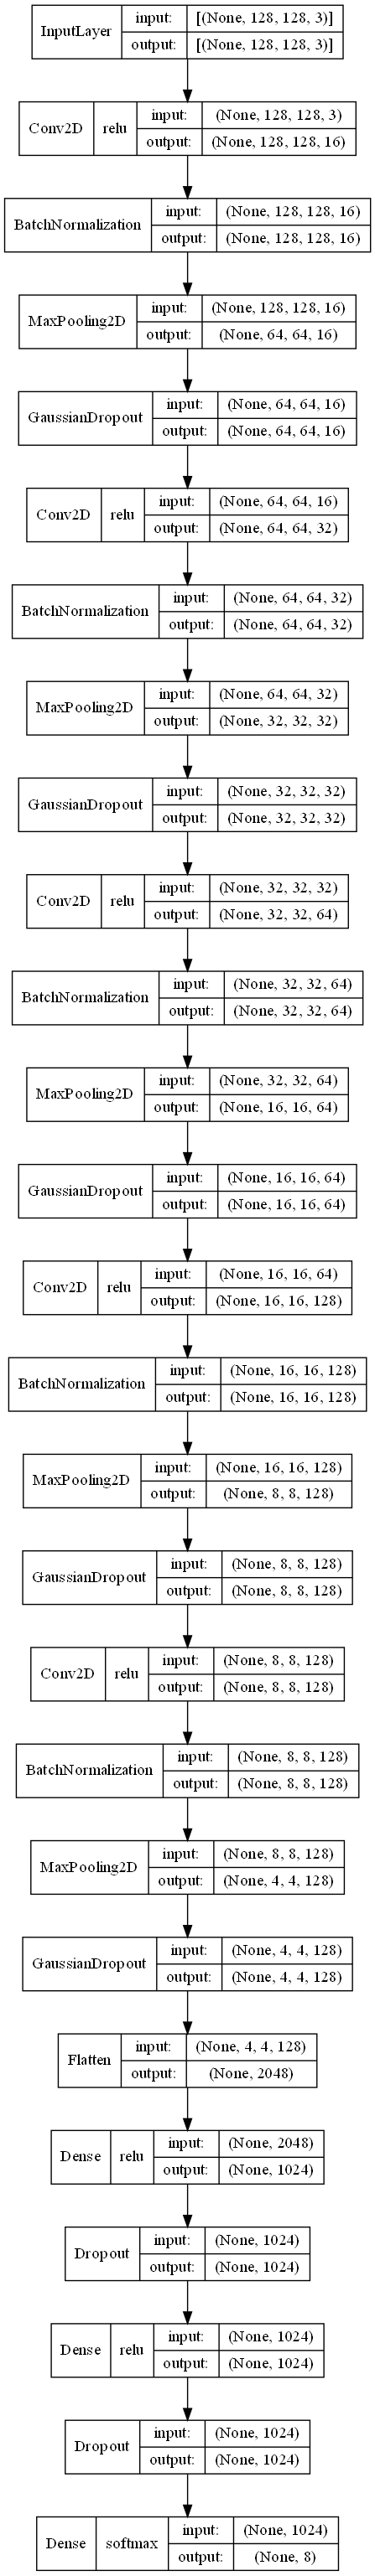

In [22]:
display_model(alex_net_v, 'alex_net_v')

Now, you can observe the detailed architecture of the AlexNet variant model.

### Train and Tune

In [18]:
class_labels = np.argmax(y_train_split, axis=1)

In [19]:
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(class_labels),
                                    y=class_labels)

class_weights = dict(enumerate(class_weights))

In [20]:
class_weights

{0: 0.9950248756218906,
 1: 0.9942004971002486,
 2: 1.0265183917878529,
 3: 1.0101010101010102,
 4: 0.9884678747940692,
 5: 1.0195412064570943,
 6: 0.9900990099009901,
 7: 0.9779951100244498}

In [21]:
def lr_scheduler(epochs, lr):
    if epochs < 5:
        return lr
    else:
        return 0.93 * lr

In [26]:
alex_net_v.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9,
                             beta_2=0.999, epsilon=10 ** (-8)),
                             loss='categorical_crossentropy',
                             metrics=[tf.keras.metrics.CategoricalAccuracy()])

First, we train the AlexNet variant model from scratch. We then fine-tune the trained model and finally compare the losses and accuracies of the trained and fine-tuned models. Let's go ahead and train the model from scratch!

In [28]:
history=alex_net_v.fit(X_train_split, y_train_split,
                       steps_per_epoch=X_train_split.shape[0] // batch_size,
                       validation_data=(X_val, y_val),
                       validation_steps=X_val.shape[0] // batch_size,
                       epochs=24,
                       class_weight=class_weights)

Epoch 1/24

32/32 [==============================] - 71s 2s/step - loss: 2.5755 - categorical_accuracy: 0.1477 - val_loss: 3.4870 - val_categorical_accuracy: 0.1294
Epoch 2/24
32/32 [==============================] - 68s 2s/step - loss: 2.0191 - categorical_accuracy: 0.1816 - val_loss: 4.4439 - val_categorical_accuracy: 0.1294
Epoch 3/24
32/32 [==============================] - 68s 2s/step - loss: 1.9433 - categorical_accuracy: 0.2157 - val_loss: 4.1007 - val_categorical_accuracy: 0.1294
Epoch 4/24
32/32 [==============================] - 68s 2s/step - loss: 1.8922 - categorical_accuracy: 0.2343 - val_loss: 3.2044 - val_categorical_accuracy: 0.1312
Epoch 5/24
32/32 [==============================] - 68s 2s/step - loss: 1.8439 - categorical_accuracy: 0.2577 - val_loss: 2.3054 - val_categorical_accuracy: 0.1606
Epoch 6/24
32/32 [==============================] - 69s 2s/step - loss: 1.8054 - categorical_accuracy: 0.2761 - val_loss: 2.0978 - val_categorical_accuracy: 0.1891
Epoch 7/24
32/3

Let's save the trained model and its history for future use

In [22]:
models_path = 'D:/University/Deep_Learning/HWs/HW02_/models/'

In [23]:
def save_model(model, model_name, history_name, model_history):
    model.save(models_path + model_name)
    np.save(models_path + history_name, model_history)

In [ ]:
save_model(alex_net_v, 'trained_alex_v.keras', 'trained_alex_v.npy', history)

In [24]:
def load_saved_model(model_name, history_name):
    model = load_model(models_path + model_name)
    history = np.load(models_path + history_name, allow_pickle=True).item()

    return model, history

In [25]:
def plot_metrics(model_history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(model_history.history['categorical_accuracy'], label='Training Accuracy')
    plt.plot(model_history.history['val_categorical_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(model_history.history['loss'], label='Training Loss')
    plt.plot(model_history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    plt.show()

In [65]:
alex_net_v_saved, alex_net_v_history = load_saved_model('trained_alex_v.keras',
                                                        'trained_alex_v.npy')

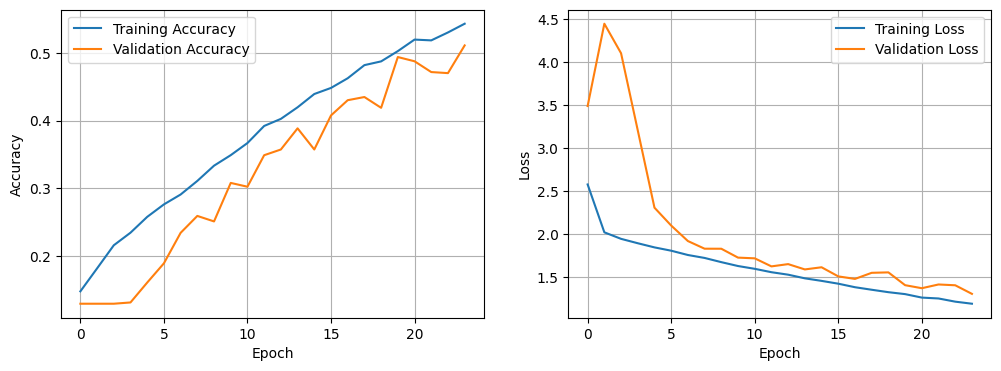

In [66]:
plot_metrics(alex_net_v_history)

In the above plots, you can observe the loss and accuracy of the training and validation datasets for a trained variant of the AlexNet model without any fine-tuning.

In [26]:
def fine_tune(model, frozens_count):

    for layer in model.layers[:frozens_count]:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.0001),
                             loss='categorical_crossentropy',
                             metrics=[tf.keras.metrics.CategoricalAccuracy()])

    lr = LearningRateScheduler(lr_scheduler)

    # # Early stopping callback
    # early_stopping = EarlyStopping(
    # monitor='val_categorical_accuracy',     # Monitor validation accuracy
    # patience=5,                             # Allow training to continue for 5 epochs without improvement
    # verbose=1,                              # Print messages about early stopping
    # restore_best_weights=True               # Restore model weights to the best epoch
    # )

    # # Model checkpoint callback
    # checkpoints = ModelCheckpoint(
    # './checkpoint',                         # Save the model checkpoints to the specified directory
    # monitor='val_categorical_accuracy',     # Monitor validation accuracy
    # save_best_only=True,                    # Save only the best model
    # verbose=1                               # Print messages about model checkpoints
    # )

    history=model.fit(X_tune_normalized, y_tune_encoded, epochs=16,
                      validation_data=(X_val, y_val),
                      class_weight=class_weights,
                      callbacks=[lr])

    return model, history


In [72]:
fine_tuned_alex_v, fine_tuned_alex_v_history = fine_tune(alex_net_v_saved, 9)

Epoch 1/16
50/50 [==============================] - 13s 225ms/step - loss: 1.5662 - categorical_accuracy: 0.4075 - val_loss: 1.5118 - val_categorical_accuracy: 0.4419 - lr: 1.0000e-04
Epoch 2/16
50/50 [==============================] - 10s 208ms/step - loss: 1.5056 - categorical_accuracy: 0.4250 - val_loss: 1.5038 - val_categorical_accuracy: 0.4400 - lr: 1.0000e-04
Epoch 3/16
50/50 [==============================] - 10s 211ms/step - loss: 1.4689 - categorical_accuracy: 0.4275 - val_loss: 1.4960 - val_categorical_accuracy: 0.4506 - lr: 1.0000e-04
Epoch 4/16
50/50 [==============================] - 11s 214ms/step - loss: 1.4673 - categorical_accuracy: 0.4387 - val_loss: 1.5220 - val_categorical_accuracy: 0.4444 - lr: 1.0000e-04
Epoch 5/16
50/50 [==============================] - 11s 220ms/step - loss: 1.4262 - categorical_accuracy: 0.4456 - val_loss: 1.5045 - val_categorical_accuracy: 0.4437 - lr: 1.0000e-04
Epoch 6/16
50/50 [==============================] - 11s 220ms/step - loss: 1.422

In [73]:
save_model(fine_tuned_alex_v, 'tuned_alex_v.keras', 'tuned_alex_v.npy',
           fine_tuned_alex_v_history)

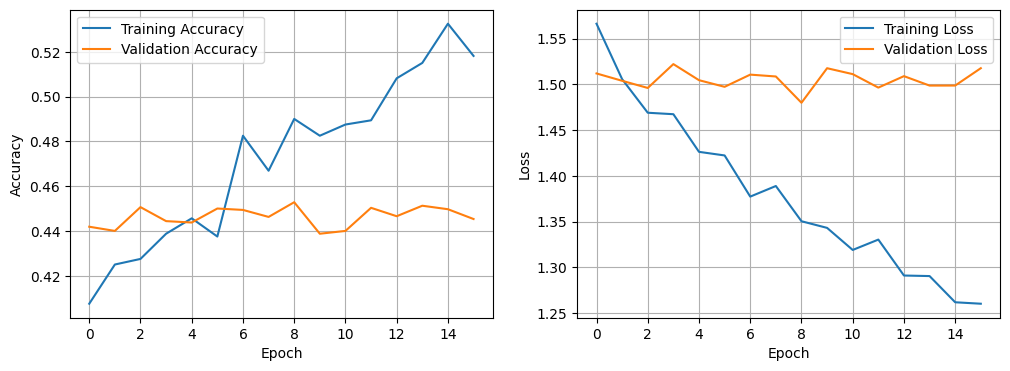

In [74]:
plot_metrics(fine_tuned_alex_v_history)

In [27]:
def draw_roc_auc(y_pred, y_true):
    n_classes = 8

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_classes):
        # fpr[i], tpr[i], _ = roc_curve(y_tune_val[:, i], y_pred[:, i])
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')  # Plot the diagonal line (random guessing)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

In [28]:
def metrics_report(y_pred, y_true):
    y_pred = np.argmax(y_pred, axis=1)
    print(classification_report(y_pred=y_pred,
                                y_true=np.argmax(y_true, axis=1)))

In [29]:
def draw_cm(y_pred, y_true):
    n_classes = 8
    y_pred = np.argmax(y_pred, axis=1)
    
    cm = confusion_matrix(np.argmax(y_true, axis=1), y_pred)

    plt.figure(figsize=(8, 6))
    
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
                xticklabels=range(n_classes),
                yticklabels=range(n_classes))
    
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    plt.title('Confusion Matrix')
    
    plt.show()

In [78]:
y_pred = fine_tuned_alex_v.predict(X_val)

100/100 [==============================] - 5s 53ms/step


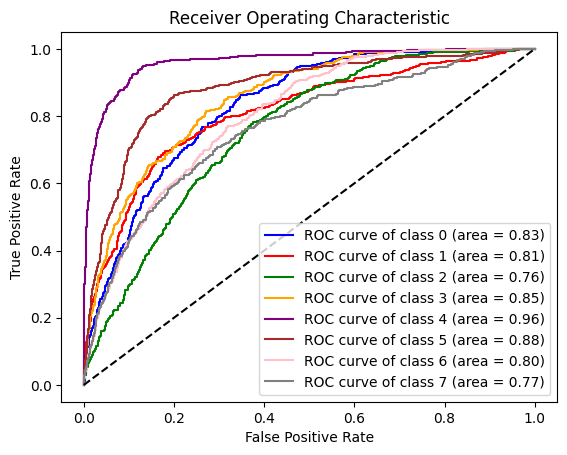

              precision    recall  f1-score   support

           0       0.44      0.28      0.34       385
           1       0.43      0.48      0.45       390
           2       0.32      0.30      0.31       402
           3       0.48      0.37      0.42       392
           4       0.60      0.90      0.72       410
           5       0.46      0.64      0.54       394
           6       0.37      0.37      0.37       414
           7       0.34      0.23      0.27       413

    accuracy                           0.45      3200
   macro avg       0.43      0.44      0.43      3200
weighted avg       0.43      0.45      0.43      3200



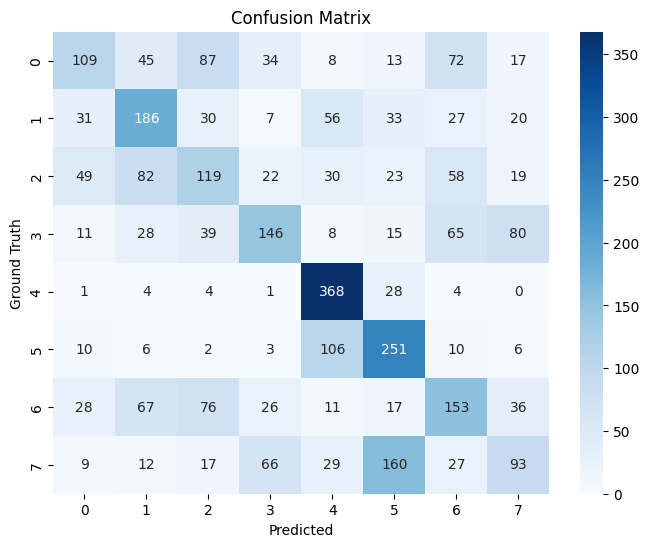

In [79]:
draw_roc_auc(y_pred, y_val)
metrics_report(y_pred, y_val)
draw_cm(y_pred, y_val)

## VGGNet Variant

### Architecture

In [30]:
def VGGNetVariant():
    model_input = layers.Input((128, 128, 3))

    x = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same',
                        activation='relu')(model_input)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same',
                        activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = layers.GaussianDropout(0.2)(x)

    x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same',
                        activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same',
                        activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = layers.GaussianDropout(0.2)(x)

    x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same',
                        activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same',
                        activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = layers.GaussianDropout(0.2)(x)

    x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same',
                        activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same',
                        activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = layers.GaussianDropout(0.2)(x)

    x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same',
                        activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same',
                        activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = layers.GaussianDropout(0.2)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(8, activation='softmax')(x)

    model = Model(inputs=model_input, outputs=x)

    return model



In [31]:
vgg_net_v = VGGNetVariant()
vgg_net_v.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 16)      64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0   

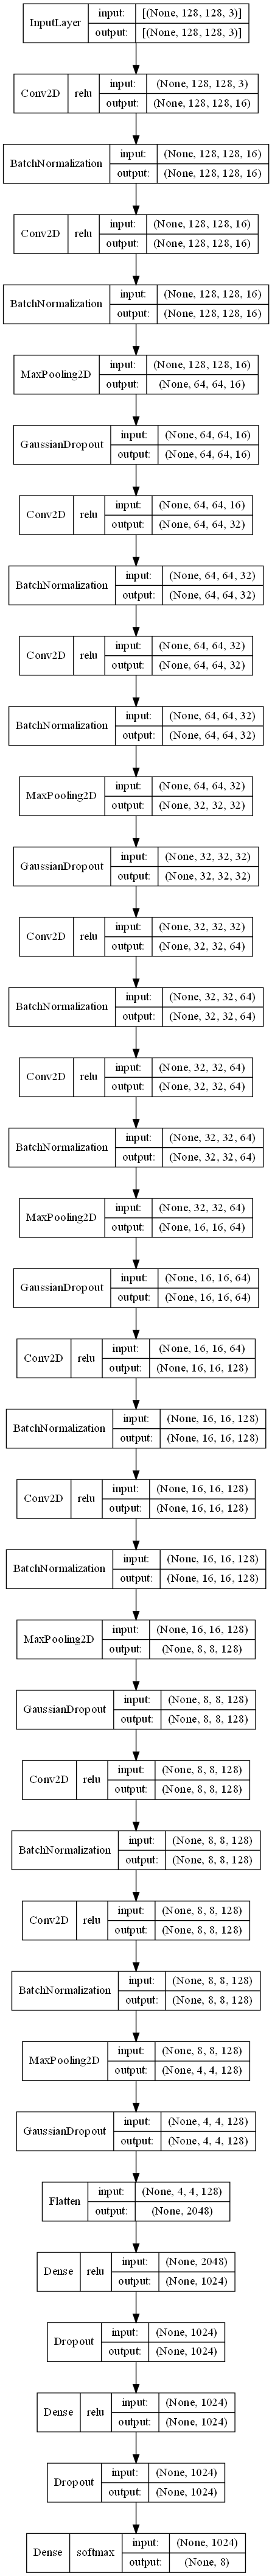

In [32]:
display_model(vgg_net_v, 'vgg_net_v')

In [33]:
vgg_net_v.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9,
                             beta_2=0.999, epsilon=10 ** (-8)),
                             loss='categorical_crossentropy',
                             metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [34]:
trained_vgg_history=vgg_net_v.fit(X_train_split, y_train_split,
                       steps_per_epoch=X_train_split.shape[0] // (batch_size * 2),
                       validation_data=(X_val, y_val),
                       validation_steps=X_val.shape[0] // (batch_size * 2),
                       epochs=24,
                       class_weight=class_weights)

Epoch 1/24

 4/12 [=========>....................] - ETA: 1:06 - loss: 5.8496 - categorical_accuracy: 0.1213

In [ ]:
save_model(vgg_net_v, 'trained_vgg_v.keras', 'trained_vgg_v.npy',
           trained_vgg_history)

In [ ]:
vgg_net_v_saved, vgg_net_v_history = load_saved_model('trained_vgg_v.keras',
                                                        'trained_vgg_v.npy')

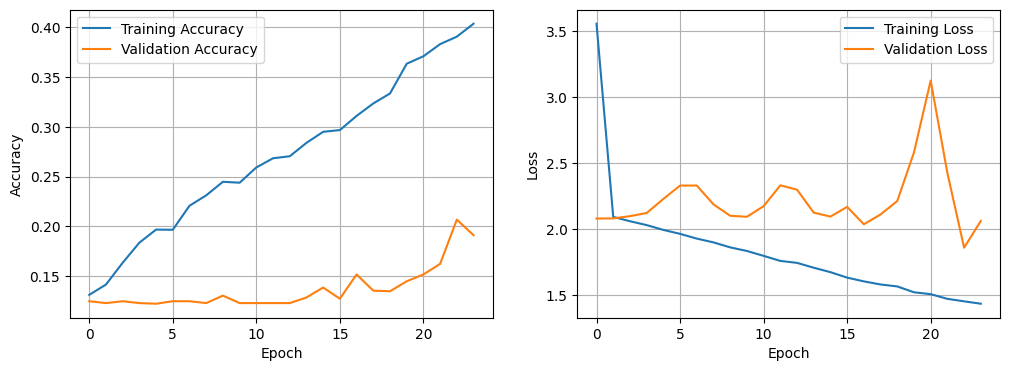

In [ ]:
plot_metrics(vgg_net_v_history)

In [ ]:
fine_tuned_vgg_v, fine_tuned_vgg_v_history = fine_tune(vgg_net_v_saved, 19)

Epoch 1/16
50/50 [==============================] - ETA: 0s - loss: 1.9474 - categorical_accuracy: 0.2450
Epoch 1: val_categorical_accuracy improved from -inf to 0.27812, saving model to .\checkpoint
INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


50/50 [==============================] - 17s 309ms/step - loss: 1.9474 - categorical_accuracy: 0.2450 - val_loss: 1.9568 - val_categorical_accuracy: 0.2781 - lr: 0.0010
Epoch 2/16
50/50 [==============================] - ETA: 0s - loss: 1.8283 - categorical_accuracy: 0.2531
Epoch 2: val_categorical_accuracy did not improve from 0.27812
50/50 [==============================] - 11s 212ms/step - loss: 1.8283 - categorical_accuracy: 0.2531 - val_loss: 2.3000 - val_categorical_accuracy: 0.2663 - lr: 0.0010
Epoch 3/16
50/50 [==============================] - ETA: 0s - loss: 1.7858 - categorical_accuracy: 0.2819
Epoch 3: val_categorical_accuracy did not improve from 0.27812
50/50 [==============================] - 11s 214ms/step - loss: 1.7858 - categorical_accuracy: 0.2819 - val_loss: 2.2357 - val_categorical_accuracy: 0.2781 - lr: 0.0010
Epoch 4/16
50/50 [==============================] - ETA: 0s - loss: 1.8034 - categorical_accuracy: 0.2688
Epoch 4: val_categorical_accuracy improved from 0

INFO:tensorflow:Assets written to: .\checkpoint\assets


50/50 [==============================] - 14s 283ms/step - loss: 1.8034 - categorical_accuracy: 0.2688 - val_loss: 2.4282 - val_categorical_accuracy: 0.2806 - lr: 0.0010
Epoch 5/16
50/50 [==============================] - ETA: 0s - loss: 1.7758 - categorical_accuracy: 0.2887
Epoch 5: val_categorical_accuracy improved from 0.28062 to 0.28313, saving model to .\checkpoint
INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


50/50 [==============================] - 14s 282ms/step - loss: 1.7758 - categorical_accuracy: 0.2887 - val_loss: 2.7299 - val_categorical_accuracy: 0.2831 - lr: 0.0010
Epoch 6/16
50/50 [==============================] - ETA: 0s - loss: 1.7912 - categorical_accuracy: 0.2837
Epoch 6: val_categorical_accuracy improved from 0.28313 to 0.28750, saving model to .\checkpoint
INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


50/50 [==============================] - 14s 287ms/step - loss: 1.7912 - categorical_accuracy: 0.2837 - val_loss: 2.0729 - val_categorical_accuracy: 0.2875 - lr: 9.3000e-04
Epoch 7/16
50/50 [==============================] - ETA: 0s - loss: 1.7949 - categorical_accuracy: 0.2656
Epoch 7: val_categorical_accuracy improved from 0.28750 to 0.30687, saving model to .\checkpoint
INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


50/50 [==============================] - 14s 279ms/step - loss: 1.7949 - categorical_accuracy: 0.2656 - val_loss: 2.2671 - val_categorical_accuracy: 0.3069 - lr: 8.6490e-04
Epoch 8/16
50/50 [==============================] - ETA: 0s - loss: 1.7291 - categorical_accuracy: 0.3000
Epoch 8: val_categorical_accuracy did not improve from 0.30687
50/50 [==============================] - 11s 217ms/step - loss: 1.7291 - categorical_accuracy: 0.3000 - val_loss: 2.4251 - val_categorical_accuracy: 0.2756 - lr: 8.0436e-04
Epoch 9/16
50/50 [==============================] - ETA: 0s - loss: 1.6717 - categorical_accuracy: 0.3206
Epoch 9: val_categorical_accuracy improved from 0.30687 to 0.32625, saving model to .\checkpoint
INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


50/50 [==============================] - 14s 286ms/step - loss: 1.6717 - categorical_accuracy: 0.3206 - val_loss: 2.2039 - val_categorical_accuracy: 0.3262 - lr: 7.4805e-04
Epoch 10/16
50/50 [==============================] - ETA: 0s - loss: 1.6289 - categorical_accuracy: 0.3537
Epoch 10: val_categorical_accuracy did not improve from 0.32625
50/50 [==============================] - 11s 219ms/step - loss: 1.6289 - categorical_accuracy: 0.3537 - val_loss: 2.8205 - val_categorical_accuracy: 0.3194 - lr: 6.9569e-04
Epoch 11/16
50/50 [==============================] - ETA: 0s - loss: 1.6384 - categorical_accuracy: 0.3450
Epoch 11: val_categorical_accuracy did not improve from 0.32625
50/50 [==============================] - 11s 216ms/step - loss: 1.6384 - categorical_accuracy: 0.3450 - val_loss: 2.5096 - val_categorical_accuracy: 0.3206 - lr: 6.4699e-04
Epoch 12/16
50/50 [==============================] - ETA: 0s - loss: 1.5526 - categorical_accuracy: 0.3825
Epoch 12: val_categorical_accura

INFO:tensorflow:Assets written to: .\checkpoint\assets


50/50 [==============================] - 14s 284ms/step - loss: 1.5526 - categorical_accuracy: 0.3825 - val_loss: 2.3120 - val_categorical_accuracy: 0.3306 - lr: 6.0170e-04
Epoch 13/16
50/50 [==============================] - ETA: 0s - loss: 1.5587 - categorical_accuracy: 0.3775
Epoch 13: val_categorical_accuracy improved from 0.33062 to 0.36187, saving model to .\checkpoint
INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


50/50 [==============================] - 14s 286ms/step - loss: 1.5587 - categorical_accuracy: 0.3775 - val_loss: 2.3228 - val_categorical_accuracy: 0.3619 - lr: 5.5958e-04
Epoch 14/16
50/50 [==============================] - ETA: 0s - loss: 1.5057 - categorical_accuracy: 0.4200
Epoch 14: val_categorical_accuracy did not improve from 0.36187
50/50 [==============================] - 11s 218ms/step - loss: 1.5057 - categorical_accuracy: 0.4200 - val_loss: 2.8770 - val_categorical_accuracy: 0.3506 - lr: 5.2041e-04
Epoch 15/16
50/50 [==============================] - ETA: 0s - loss: 1.4631 - categorical_accuracy: 0.4363
Epoch 15: val_categorical_accuracy did not improve from 0.36187
50/50 [==============================] - 11s 216ms/step - loss: 1.4631 - categorical_accuracy: 0.4363 - val_loss: 2.8163 - val_categorical_accuracy: 0.3487 - lr: 4.8398e-04
Epoch 16/16
50/50 [==============================] - ETA: 0s - loss: 1.4806 - categorical_accuracy: 0.4219
Epoch 16: val_categorical_accura

INFO:tensorflow:Assets written to: .\checkpoint\assets


50/50 [==============================] - 14s 285ms/step - loss: 1.4806 - categorical_accuracy: 0.4219 - val_loss: 2.3108 - val_categorical_accuracy: 0.3663 - lr: 4.5010e-04


In [ ]:
save_model(fine_tuned_vgg_v, 'fine_tuned_vgg.keras',
           'fine_tuned_vgg_history.npy', fine_tuned_vgg_v_history)

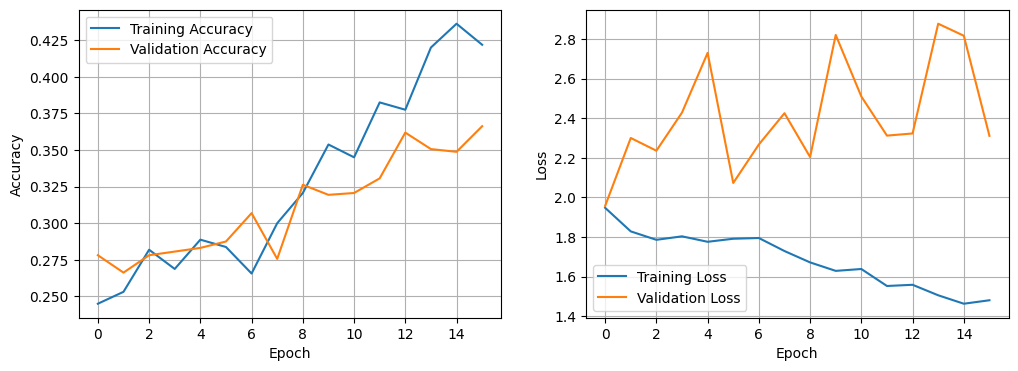

In [ ]:
plot_metrics(fine_tuned_vgg_v_history)

In [ ]:
y_pred = fine_tuned_vgg_v.predict(X_val)

50/50 [==============================] - 4s 80ms/step


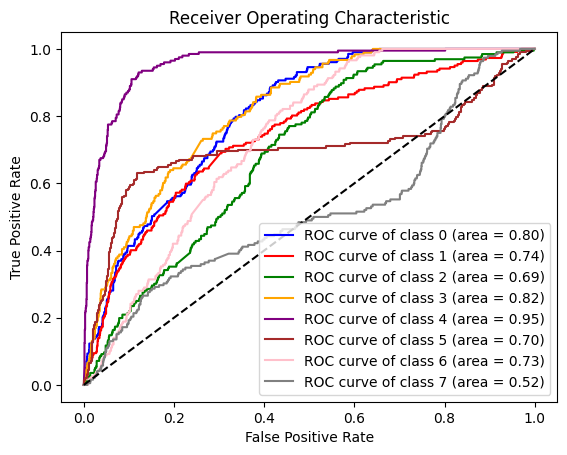

              precision    recall  f1-score   support

           0       0.27      0.48      0.35       203
           1       0.43      0.32      0.36       222
           2       0.20      0.03      0.05       196
           3       0.39      0.28      0.33       183
           4       0.54      0.92      0.68       200
           5       0.40      0.50      0.45       197
           6       0.23      0.29      0.26       207
           7       0.24      0.11      0.15       192

    accuracy                           0.37      1600
   macro avg       0.34      0.36      0.33      1600
weighted avg       0.34      0.37      0.33      1600



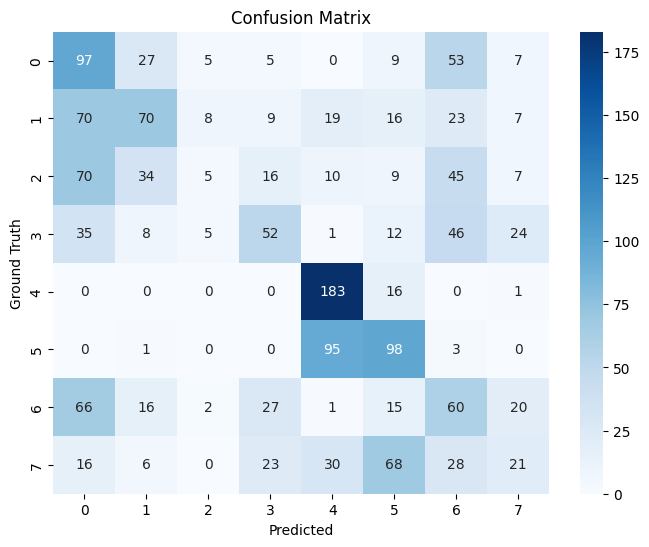

In [ ]:
draw_roc_auc(y_pred, y_val)
metrics_report(y_pred, y_val)
draw_cm(y_pred, y_val)

## MobileNet Variant

### Architecture

In [ ]:
def MobileNetVariant():
    model_input = layers.Input((128, 128, 3))

    x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2),
                        activation='relu')(model_input)

    x = layers.SeparableConv2D(filters=64, kernel_size=(3, 3),
                               padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=64, kernel_size=(1, 1), activation='relu')(x)

    x = layers.SeparableConv2D(filters=128, kernel_size=(3, 3),
                               strides=(2, 2), activation='relu')(x)
    x = layers.Conv2D(filters=128, kernel_size=(1, 1), activation='relu')(x)

    x = layers.SeparableConv2D(filters=128, kernel_size=(3, 3),
                               padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=128, kernel_size=(1, 1), activation='relu')(x)

    x = layers.SeparableConv2D(filters=256, kernel_size=(3, 3),
                               strides=(2, 2), activation='relu')(x)
    x = layers.Conv2D(filters=256, kernel_size=(1, 1), activation='relu')(x)

    x = layers.SeparableConv2D(filters=256, kernel_size=(3, 3),
                               padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=256, kernel_size=(1, 1), activation='relu')(x)

    x = layers.SeparableConv2D(filters=512, kernel_size=(3, 3),
                               strides=(2, 2), activation='relu')(x)
    x = layers.Conv2D(filters=512, kernel_size=(1, 1), activation='relu')(x)

    x = layers.SeparableConv2D(filters=512, kernel_size=(3, 3),
                               padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=512, kernel_size=(1, 1), activation='relu')(x)

    x = layers.SeparableConv2D(filters=1024, kernel_size=(3, 3),
                               strides=(2, 2), activation='relu')(x)
    x = layers.Conv2D(filters=1024, kernel_size=(1, 1), activation='relu')(x)

    x = layers.SeparableConv2D(filters=1024, kernel_size=(3, 3),
                               padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=1024, kernel_size=(1, 1), activation='relu')(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(8, activation='softmax')(x)

    model = Model(inputs=model_input, outputs=x)

    return model

In [ ]:
mobile_net_v = MobileNetVariant()
mobile_net_v.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 63, 63, 32)        896       
                                                                 
 separable_conv2d (Separabl  (None, 63, 63, 64)        2400      
 eConv2D)                                                        
                                                                 
 conv2d_16 (Conv2D)          (None, 63, 63, 64)        4160      
                                                                 
 separable_conv2d_1 (Separa  (None, 31, 31, 128)       8896      
 bleConv2D)                                                      
                                                                 
 conv2d_17 (Conv2D)          (None, 31, 31, 128)       1651

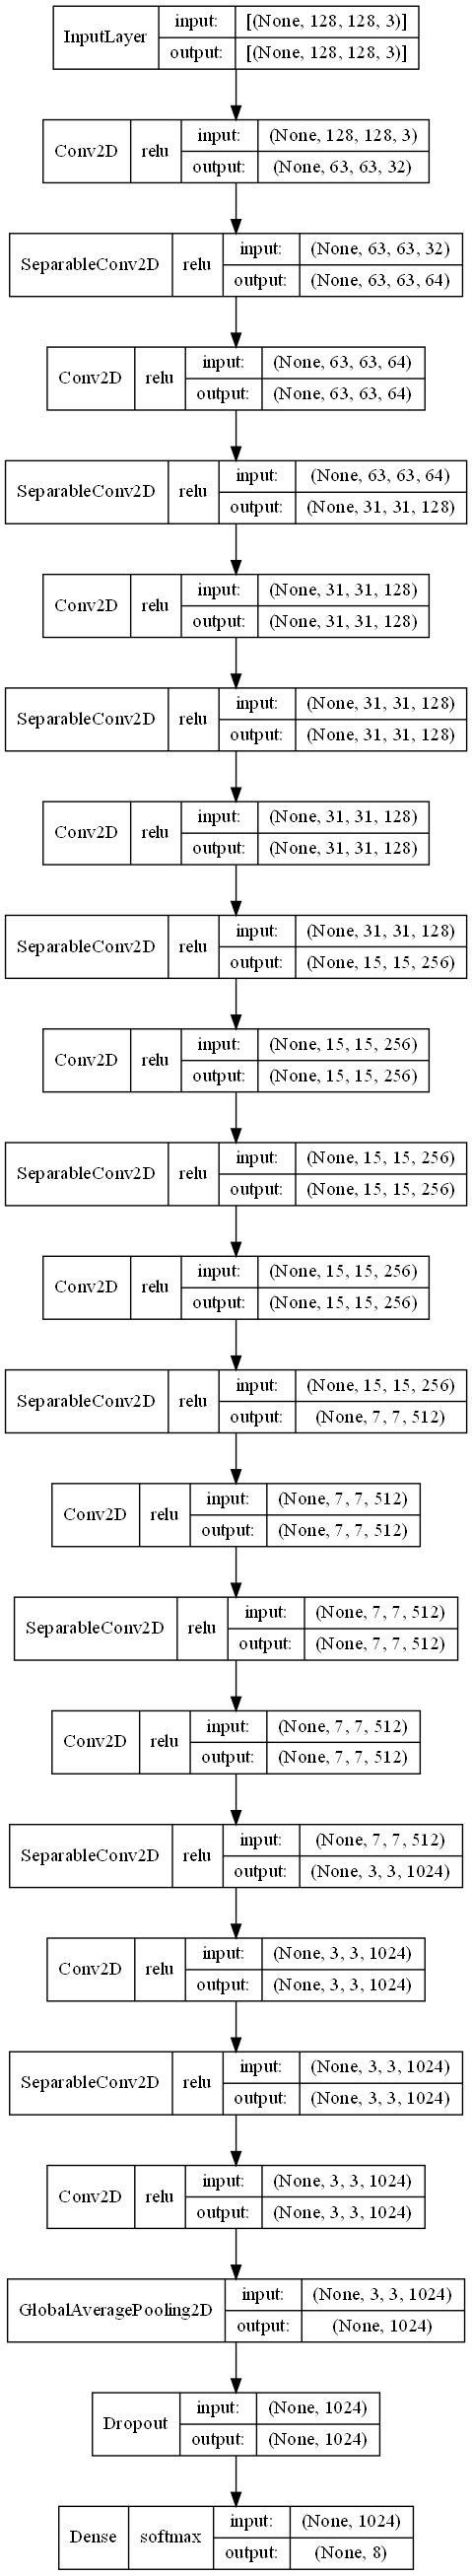

In [ ]:
display_model(mobile_net_v, 'mobile_net_v')

In [ ]:
mobile_net_v.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9,
                             beta_2=0.999, epsilon=10 ** (-8),
                             weight_decay=0.01),
                             loss='categorical_crossentropy',
                             metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
# trained_mobile_history = mobile_net_v.fit(train_gen,
#                                         epochs=24, steps_per_epoch=steps_per_epoch,
#                                         batch_size=batch_size, validation_split=0.2,
#                                         class_weight=class_weights)

# lr = LearningRateScheduler(lr_scheduler_t)

trained_mobile_history=mobile_net_v.fit(X_train_split, y_train_split,
                       steps_per_epoch=X_train_split.shape[0] // batch_size,
                       validation_data=(X_val, y_val),
                       validation_steps=X_val.shape[0] // batch_size,
                       epochs=24,
                       class_weight=class_weights)


Epoch 1/24
200/200 [==============================] - 64s 299ms/step - loss: 2.0802 - categorical_accuracy: 0.1203 - val_loss: 2.0794 - val_categorical_accuracy: 0.1200
Epoch 2/24
200/200 [==============================] - 55s 275ms/step - loss: 2.0798 - categorical_accuracy: 0.1200 - val_loss: 2.0794 - val_categorical_accuracy: 0.1144
Epoch 3/24
200/200 [==============================] - 55s 273ms/step - loss: 2.0797 - categorical_accuracy: 0.1211 - val_loss: 2.0795 - val_categorical_accuracy: 0.1144
Epoch 4/24
 20/200 [==>...........................] - ETA: 46s - loss: 2.0788 - categorical_accuracy: 0.1281

KeyboardInterrupt: 

In [ ]:
save_model(mobile_net_v, 'trained_mobile_v.keras', 'trained_mobile_v.npy',
           trained_mobile_history)

In [ ]:
mobile_net_v_saved, mobile_net_v_history = load_saved_model('trained_mobile_v.keras',
                                                        'trained_mobile_v.npy')

In [ ]:
plot_metrics(mobile_net_v_history)

In [ ]:
fine_tuned_mobile_v, fine_tuned_mobile_v_history = fine_tune(mobile_net_v_saved, 9)

In [ ]:
plot_metrics(fine_tuned_mobile_v_history)

In [ ]:
y_pred = fine_tuned_mobile_v.predict(X_val)

In [ ]:
draw_roc_auc(y_pred, y_val)
metrics_report(y_pred, y_val)
draw_cm(y_pred, y_val)